## Importing Dependencies

In [1]:
!pip install gymnasium

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import gymnasium as gym
from IPython.display import HTML, display

## Creating the FrozenLake Environment

This section creates the FrozenLake environment from Gymnasium, a 4x4 grid world where an agent has to navigate through a grid to reach the goal.

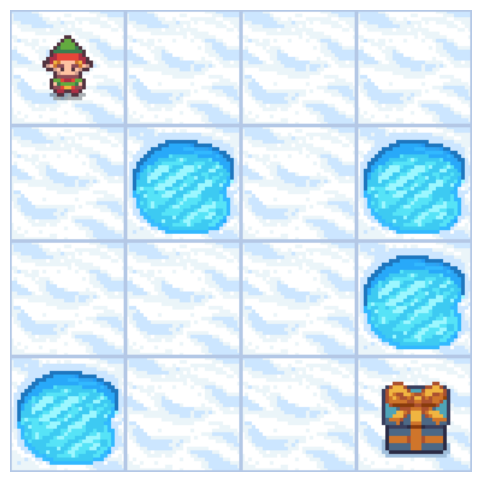

In [3]:
env = gym.make('FrozenLake-v1', map_name=f'4x4', is_slippery=False, render_mode='rgb_array')
n_state = env.observation_space.n
n_actions = env.action_space.n
nrow, ncol = env.unwrapped.desc.shape

np.random.seed(42)
env.reset(seed=42)
plt.figure(figsize=(6, 6))
plt.imshow(env.render())
plt.axis('off')
plt.show()

## Helper Functions

In [4]:
def plot_value_map(value_map, title):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(value_map.reshape(nrow, ncol), cmap='viridis', interpolation='nearest')
    ax.set_title(title)
    for (i, j), v in np.ndenumerate(value_map):
        texts.append(ax.text(j + 0.25, i + 0.25, f'{v:.2f}', ha='center', va='center', fontsize=12, color='white'))
    plt.show()

def plot_policy(policy, title):
    action_map = np.array([['←', '↓', '→', '↑'][a] for a in policy])
    action_map = action_map.reshape(nrow, ncol)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(np.zeros((nrow, ncol)), cmap='Blues', interpolation='nearest')

    ax.set_title(title)
    for (i, j), v in np.ndenumerate(action_map):
        texts.append(ax.text(j, i, v, ha='center', va='center', fontsize=12, color='black'))

    for i in range(nrow - 1):
        ax.axhline(i + 0.5, color='black', linewidth=1)
    for i in range(ncol - 1):
        ax.axvline(i + 0.5, color='black', linewidth=1)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

texts = []
def update_value_animation(ax, value_changes, title, frame):
    for text in texts:
        text.remove()
    texts.clear()
    episode, value_map = value_changes[frame]
    value_map = value_map.reshape(nrow, ncol)
    ax.imshow(value_map, cmap='viridis', interpolation='nearest')
    ax.set_title(f"{title} - Episode {episode}")
    for (i, j), v in np.ndenumerate(value_map):
        texts.append(ax.text(j + 0.25, i + 0.25, f'{v:.2f}', ha='center', va='center', fontsize=12, color='white'))

def update_policy_animation(ax, q_changes, title, frame):
    for text in texts:
        text.remove()
    texts.clear()
    episode, q_map = q_changes[frame]
    q_map = q_map.reshape(nrow, ncol, n_actions)
    ax.imshow(np.max(q_map, axis=-1), cmap='viridis', interpolation='nearest')
    ax.set_title(f"{title} - Episode {episode}")
    for i in range(nrow):
        for j in range(ncol):
            action = np.array(['←', '↓', '→', '↑'][np.argmax(q_map[i, j])])
            texts.append(ax.text(j + 0.25, i + 0.25, f'{np.max(q_map[i, j], axis=-1):.2f}', ha='center', va='center', fontsize=12, color='white'))
            texts.append(ax.text(j, i, action, ha='center', va='center', fontsize=12, color='white'))

## Value prediction: Monte Carlo vs TD(0) vs TD(λ)

### Manually Creating a Policy

In this section, we will manually create a ε-greedy policy for the FrozenLake environment, then compare the value prediction of Monte Carlo, TD(0), and TD(λ) methods.

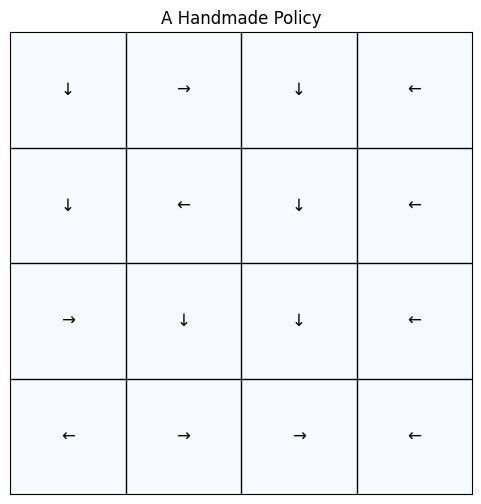

In [5]:
epsilon = 0.1
policy = np.zeros([n_state, n_actions])
optimal_actions = [1, 2, 1, 0,
                   1, 0, 1, 0,
                   2, 1, 1, 0,
                   0, 2, 2, 0]
# Create ε-greedy policy
for state in range(n_state):
    for action in range(n_actions):
        if action == optimal_actions[state]:
            policy[state][action] = 1 - epsilon + 1 / n_actions * epsilon
        else:
            policy[state][action] = 1 / n_actions * epsilon

plot_policy(np.argmax(policy, axis=1), 'A Handmade Policy')

### Monte Carlo Prediction

The Monte Carlo method uses episodes to estimate the value function by averaging returns after every visit to a state.

In [6]:
def monte_carlo_prediction(env, policy, num_episodes=2000, epsilon=0.1, gamma=0.9, plot_every=200):
    # Initialize the value function to zeros
    V = np.zeros(env.observation_space.n)
    returns = {state: [] for state in range(env.observation_space.n)}
    value_changes = [(0, V.copy())]
    for episode in range(num_episodes):
        # Generate an episode
        episode_data = []
        state = env.reset()[0]
        done = False
        while not done:
            # action = np.random.choice(env.action_space.n)
            action = np.random.choice(env.action_space.n, p=policy[state])
            next_state, reward, done, _, _ = env.step(action)
            episode_data.append((state, reward))
            state = next_state
        # Update value function based on returns
        G = 0
        for state, reward in reversed(episode_data):
            G = gamma * G + reward
            returns[state].append(G)
            V[state] = np.mean(returns[state])
        if (episode + 1) % plot_every == 0:
            value_changes.append((episode + 1, V.copy()))
    return V, value_changes

### TD(0) Method Implementation
The TD(0) method updates the value function after each step based on the observed reward and the value of the next state.

In [7]:
def td_0_prediction(env, policy, num_episodes=2000, alpha=0.1, gamma=0.9, plot_every=200):
    # Initialize the value function to zeros
    V = np.zeros(env.observation_space.n)
    value_changes = [(0, V.copy())]
    for episode in range(num_episodes):
        state, _ = env.reset()
        terminated = False
        while not terminated:
            action = np.random.choice(env.action_space.n, p=policy[state])
            next_state, reward, terminated, truncated, _ = env.step(action)
            V[state] += alpha * (reward + gamma * V[next_state] - V[state])
            state = next_state
        if (episode + 1) % plot_every == 0:
            value_changes.append((episode + 1, V.copy()))
    return V, value_changes

### TD(λ) Method Implementation
The TD(λ) method uses eligibility traces, which allow it to update values of states more effectively, considering a combination of past states and their visits.

In [8]:
def td_lambda_prediction(env, policy, num_episodes=2000, alpha=0.1, gamma=0.9, lambda_param=0.8, plot_every=200):
    # Initialize the value function to zeros
    V = np.zeros(env.observation_space.n)
    value_changes = [(0, V.copy())]
    for episode in range(num_episodes):
        state = env.reset()[0]
        terminated = False
        eligibility_traces = np.zeros(env.observation_space.n)
        while not terminated:
            action = np.random.choice(env.action_space.n, p=policy[state])
            next_state, reward, terminated, truncated, _ = env.step(action)
            delta = reward + gamma * V[next_state] - V[state]
            eligibility_traces[state] += 1
            V += alpha * delta * eligibility_traces
            eligibility_traces *= gamma * lambda_param
            state = next_state
        if (episode + 1) % plot_every == 0:
            value_changes.append((episode + 1, V.copy()))
    return V, value_changes

### Running the Algorithms and Comparing Results
Now we run the Monte Carlo, TD(0), and TD(λ) algorithms and compare their results using the value changes over time.

In [9]:
# Run Monte Carlo
V_mc, value_changes_mc = monte_carlo_prediction(env, policy)

# Run TD(0)
V_td0, value_changes_td0 = td_0_prediction(env, policy)

# Run TD(λ)
V_td_lambda, value_changes_td_lambda = td_lambda_prediction(env, policy)


### Visualization Animation: Value Changes for Monte Carlo
This section creates and displays an animation of the value function changes over iterations for the Monte Carlo method.

In [10]:
fig_mc, ax_mc = plt.subplots(figsize=(6, 6))
ax_mc.axis('off')
ani_mc = animation.FuncAnimation(
    fig_mc,
    lambda frame: update_value_animation(ax_mc, value_changes_mc, 'Monte Carlo', frame),
    frames=len(value_changes_mc),
    repeat=True
)
plt.close(fig_mc)
display(HTML(ani_mc.to_jshtml()))

### Visualization Animation: Value Changes for TD(0)
This section creates and displays an animation of the value function changes over iterations for the TD(0) method.

In [11]:
fig_td0, ax_td0 = plt.subplots(figsize=(6, 6))
ax_td0.axis('off')
ani_td0 = animation.FuncAnimation(
    fig_td0,
    lambda frame: update_value_animation(ax_td0, value_changes_td0, 'TD(0)', frame),
    frames=len(value_changes_td0),
    repeat=True
)
plt.close(fig_td0)
display(HTML(ani_td0.to_jshtml()))

### Visualization Animation: Value Changes for TD(λ)
This section creates and displays an animation of the value function changes over iterations for the TD(λ) method.

In [12]:
fig_td_lambda, ax_td_lambda = plt.subplots(figsize=(6, 6))
ax_td_lambda.axis('off')
ani_td_lambda = animation.FuncAnimation(
    fig_td_lambda,
    lambda frame: update_value_animation(ax_td_lambda, value_changes_td_lambda, 'TD(λ)', frame),
    frames=len(value_changes_td_lambda),
    repeat=True
)
plt.close(fig_td_lambda)
display(HTML(ani_td_lambda.to_jshtml()))

## TD Control: SARSA vs Q-Learning

### On policy TD control: SARSA

In [13]:
def sarsa(env, num_episodes=2000, alpha=0.1, gamma=0.9, epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.999, plot_every=200):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    q_changes = [(0, Q.copy())]
    rewards = []
    epsilon = epsilon_start

    for episode in range(num_episodes):
        state, _ = env.reset()
        terminated = False
        episode_reward = 0

        # ε-greedy policy
        action = np.random.choice(env.action_space.n) if np.random.rand() < epsilon else np.argmax(Q[state])

        while not terminated:
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            next_action = np.random.choice(env.action_space.n) if np.random.rand() < epsilon else np.argmax(Q[next_state])
            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])
            state, action = next_state, next_action

        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        rewards.append(episode_reward)
        if (episode + 1) % plot_every == 0:
            q_changes.append((episode + 1, Q.copy()))  # Use the maximum Q-value to approximate the value function

    return Q, q_changes, rewards


### Off-policy TD control: Q-Learning

In [14]:
def q_learning(env, num_episodes=2000, alpha=0.1, gamma=0.9, epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.999, plot_every=200):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    q_changes = [(0, Q.copy())]
    rewards = []
    epsilon = epsilon_start

    for episode in range(num_episodes):
        state, _ = env.reset()
        terminated = False
        episode_reward = 0

        while not terminated:
            action = np.random.choice(env.action_space.n) if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
            state = next_state

        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        rewards.append(episode_reward)
        if (episode + 1) % plot_every == 0:
            q_changes.append((episode + 1, Q.copy()))

    return Q, q_changes, rewards

### Running the Algorithms and Comparing Results
Now we run the Monte Carlo, SARSA, and Q-Learning algorithms and compare their results.

In [15]:
# Run SARSA
Q_sarsa, q_changes_sarsa, rewards_sarsa = sarsa(env)

# Run Q-Learning
Q_q_learning, q_changes_q_learning, rewards_q_learning = q_learning(env)

### Visualization Animation: SARSA
This section creates and displays an animation of the Q function and policy changes over iterations for the SARSA method.

In [16]:
fig_sarsa, ax_sarsa = plt.subplots(figsize=(6, 6))
ax_sarsa.axis('off')
ani_sarsa = animation.FuncAnimation(
    fig_sarsa,
    lambda frame: update_policy_animation(ax_sarsa, q_changes_sarsa, 'SARSA', frame),
    frames=len(q_changes_sarsa),
    repeat=True
)
plt.close(fig_sarsa)
display(HTML(ani_sarsa.to_jshtml()))

### Visualization Animation: Q-Learning
This section creates and displays an animation of the Q function and policy changes over iterations for the Q-Learning method.

In [17]:
fig_q_learning, ax_q_learning = plt.subplots(figsize=(6, 6))
ax_q_learning.axis('off')
ani_q_learning = animation.FuncAnimation(
    fig_q_learning,
    lambda frame: update_policy_animation(ax_q_learning, q_changes_q_learning, 'Q-Learning', frame),
    frames=len(q_changes_q_learning),
    repeat=True
)
plt.close(fig_q_learning)
display(HTML(ani_q_learning.to_jshtml()))

### Reward curve: SARSA vs Q-Learning

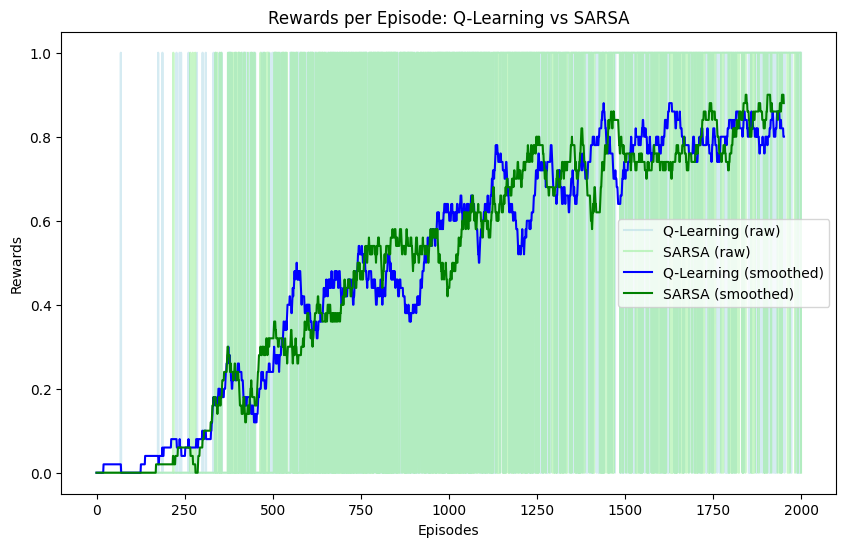

In [18]:
def smooth_rewards(rewards, window_size=50):
    window = np.ones(window_size) / window_size
    return np.convolve(rewards, window, mode='valid')

smoothed_rewards_q_learning = smooth_rewards(rewards_q_learning)
smoothed_rewards_sarsa = smooth_rewards(rewards_sarsa)

plt.figure(figsize=(10, 6))
plt.plot(rewards_q_learning, color='lightblue', alpha=0.5, label='Q-Learning (raw)')
plt.plot(rewards_sarsa, color='lightgreen', alpha=0.5, label='SARSA (raw)')
plt.plot(smoothed_rewards_q_learning, color='blue', label='Q-Learning (smoothed)')
plt.plot(smoothed_rewards_sarsa, color='green', label='SARSA (smoothed)')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Rewards per Episode: Q-Learning vs SARSA')
plt.legend()
plt.show()